# Ch7 Ensemble Learning and Random Forests

**앙상블 방법**(Ensemble method): 일련의 예측기(=앙상블)로부터 예측을 수집하여 가장 좋은 하나의 모델보다 더 좋은 예측을 얻는 학습의 알고리즘<br>
**랜덤 포레스트**(Random Forest): 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킨 결정 트리의 앙상블

In [1]:
import pandas as pd
import numpy as np
import os

import sklearn
assert sklearn.__version__ >= "0.20"

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## 7.1 투표 기반 분류기

**직접 투표**(hard voting) 분류기: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 다수결 투표로 정해지는 분류기

다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음.<br>
=> 각 분류기가 **약한 학습기**(weak learner)(즉, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)일지라도 충분하게 많고 다양하다면 앙상블은 (높은 정확도를 내는) **강한 학습기**(strong learner)가 될 수 있음.

**큰 수의 법칙**(law of large numbers): 경험적 확률과 수학적 확률 사이의 관계를 나타내는 법칙<br>표본집단의 크기가 커지면 그 표본평균이 모평균에 가까워짐.<br>=> 취합하는 표본의 수가 많을수록 통계적 정확도는 올라감.

앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능 발휘. 
<br>다양한 분류기를 얻는 방법 중하나로는 각기 다른 알고리즘으로 학습시키는 것. 이렇게 할 시에 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킴.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], 
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

각 분류기의 테스트셋 정확도 확인

In [4]:
from  sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


=> 예상과 같이 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음

**간접 투표**(soft voting): 모든 분류기가 클래스의 확률을 예측할 수 있을 때(즉, predict_proba() 메서드가 있을 때), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 방식.<br>
이는 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음.<br>
`voting="soft"` 로 바꾸고 모든 분류기가 클래스의 확률 추정 가능하면 사용 가능.

참고) SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability의 매개변수를 True로 지정해야함 (이렇게 했을시 클래스 확률을 추정하기 위해 교차 검증을 사용하므로 훈련 속도가 느려지지만 SVC에서 predict_proba() 메서드를 사용 가능

In [7]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [8]:
from  sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2 배깅과 페이스팅

#### 다양한 분류기를 만드는 방법
1. 각기 다른 훈련 알고리즘을 사용
2. 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키기

**배깅**(bagging): 훈련 세트에서 중복을 허용하여 샘플링하는 방식 (bootstrap aggregating의 줄임말)<br>
**페이스팅**(pasting): 훈련세트에서 중복을 허용하지 않고 샘플링하는 방식

배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용 가능, 무작위 샘플링<br>
but 배깅만 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링 가능

앙상블은 모든 예측기가 훈련을 마치면 이들의 예측을 모아 새로운 샘플에 대한 예측을 만듦.<br>
=> 분류일 때는 **통계적 최빈값**(statistical mode)(즉, 직접 투표 분류기처럼 가장 많은 예측 결과), <br>회귀일 때는 평균을 계산.

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소. 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦.

### 7.2.1 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 BaggingClassifier (회귀일 경우 BaggingRegressor) 제공.<br> (페이스팅을 사용할 경우 bootstrap=False 지정)

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1) # n_jobs: 사이킷런이 훈련과 예측에 사용할 CPU 코어수를 지정(-1은 가용한 모든 코어 사용)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용)

In [11]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


=> Decision Tree 하나의 예측보다 앙상블의 예측이 일반화가 더 잘 되었음.<br>
=> 앙상블은 비슷한 편향에서 더 작은 분산을 만듦.

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음. 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이는 것이므로 앙상블의 분산 감소시킴.

### 7.2.2 oob 평가

**obb**(out-of-bag): 배깅을 사용할 때 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있는데 이때 선택되지 않은 훈련 샘플

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가 할 수 있음. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음.

사이킷런에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행. 평가 점수 결과는 oob_score_ 변수에 저장되어있음.

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [13]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

oob 평가 결과와 BaggingClassifier의 테스트셋 정확도는 비슷.

oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인 가능. ([negative prob, positive prob]의 순서)<br>
이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환.

In [15]:
bag_clf.oob_decision_function_

array([[0.38829787, 0.61170213],
       [0.34269663, 0.65730337],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06508876, 0.93491124],
       [0.33695652, 0.66304348],
       [0.01020408, 0.98979592],
       [0.98484848, 0.01515152],
       [0.98295455, 0.01704545],
       [0.77884615, 0.22115385],
       [0.01020408, 0.98979592],
       [0.75897436, 0.24102564],
       [0.80104712, 0.19895288],
       [0.96022727, 0.03977273],
       [0.06470588, 0.93529412],
       [0.        , 1.        ],
       [0.98857143, 0.01142857],
       [0.94545455, 0.05454545],
       [0.98802395, 0.01197605],
       [0.01142857, 0.98857143],
       [0.33668342, 0.66331658],
       [0.92424242, 0.07575758],
       [1.        , 0.        ],
       [0.99450549, 0.00549451],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.68811881, 0.31188119],
       [0.

In [16]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.896

## 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원. 샘플링은 max_features, bootstrap_features 두 매개변수로 조절. 이는 '특성'에 대한 샘플링이기 때문에 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨.

**랜덤 패치 방식**(random patches method): 훈련 특성과 샘플을 모두 샘플링하는 것

**랜덤 서브스페이스 방식**(random subspaces method): 훈련 샘플을 모두 사용하고 (bootstrap=False 이고 max_samples=1.0 으로 설정) 특성은 샘플링(bootstrap_features=True 그리고/또는 max_features는 1.0보다 작게 설정)

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트

**랜덤 포레스트**는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블.<br>
전형적으로 max_samples를 훈련 세트의 크기로 지정. <br>
BaggingClassifier에 결정 트리에 최적화되어 사용하기 편리한 RandomForestClasifier를 사용 (회귀일 경우 RandomForestRegressor)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함<br>
=> 이는 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델 생성.

BaggingClassifier를 사용하여 앞의 RandomForestClassifier와 거의 유사하게 만든 것.

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [20]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [21]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일

0.992

### 7.4.1 엑스트라 트리

랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용. 

**익스트림 랜덤 트리**(extremely randomized trees 또는 extra-trees): 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그 중에서 최상의 분할을 선택하여 극단적으로 무작위한 트리의 랜덤 포레스트

=> 이때도 편향이 늘지만 분산이 낮아짐.<br>
=> 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 더 빠름

사이킷런의 **ExtraTreesClassifier**를 사용

### 7.4.2 특성 중요도

랜덤 포레스트의 장점: 특성의 상대적 중요도를 측정하기 쉬움. 사이킷런은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성 중요도를 측정<br>
-> 엄밀히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.<br>
=> 이 값은 **feature_importances_** 변수에 저장되어 있음.

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [23]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특서이 중요한지 빠르게 확인할 수 있어 매우 편리

## 7.5 부스팅

**부스팅**(boosting): 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 학습 방법<br>
-> 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴

### 7.5.1 에이다부스트

**에이다부스트**(adaboost): 이전 예측기를 보완하는 새로운 예측기를 만드는 방법으로 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것. 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.

에이다부스트 분류기 만드는 예시
1. 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다.
2. 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다.
3. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다.
4. 그 다음에 다시 가중치를 업데이트하는 식으로 계속된다.

에이다부스트는 비용 함수가 점차 더 좋아지도록 앙상블에 예측기를 추가함.<br>
모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦.<br>
가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨.

주의) 연속된 학습 기법에서의 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)를 할 수 없음. 결국 배깅이나 페이스팅만큼 확장성이 높지 않음.

사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용.<br>
-> 클래스가 두 개뿐일 때는 SAMME와 에이다부스트는 동일<br>
예측기가 클래스의 확률을 추정할 수 있다면 사이킷런은 SAMME.R이라는 SAMME의 변종 사용.<br>
=> 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다.

사이킷런의 AdaBoostClassifier 사용하여 200개의 아주 얕은 결정 트리를 기반으로 하는 에이다부스트 분류기<br>
-> 여기서 결정 트리는 max_depth=1; 결정 노드 하나와 리프 노드 두 개로 이루어진 트리<br>
=> 이 트리가 AdaBoostClassifier의 기본 추정기

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

tip) 에이다부스트 앙상블이 훈련 세트에 과대적합되면 추정기 술르 줄이거나 추정기의 규제를 더 강하게 해볼 것.

### 7.5.2 그레이디언트 부스팅

**그레이디언트 부스팅**(gradient boosting): 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가. 이전 예측기가 만든 **잔여 오차**(residual error)에 새로운 예측기를 학습시킴.

**그레이디언트 트리 부스팅**(gradient tree boosting) 또는 **그레이디언트 부스티드 회귀 트리**(gradient boosted regression tree)(GBRT)

먼저 DecisionTreeRegressor를 훈련 세트에 학습 시켜보자.

In [24]:
# 새로운 데이터셋
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련 시키기.

In [26]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

그 다음 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련시키기.

In [27]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

이렇게 하면 세 개의 트리를 포함하는 앙상블 모델이 생김. 새로운 샘플에 대한 예측을 만드려면 모든 트리의 예측을 더하면 된다.

In [28]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [29]:
# 그래프 코드
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

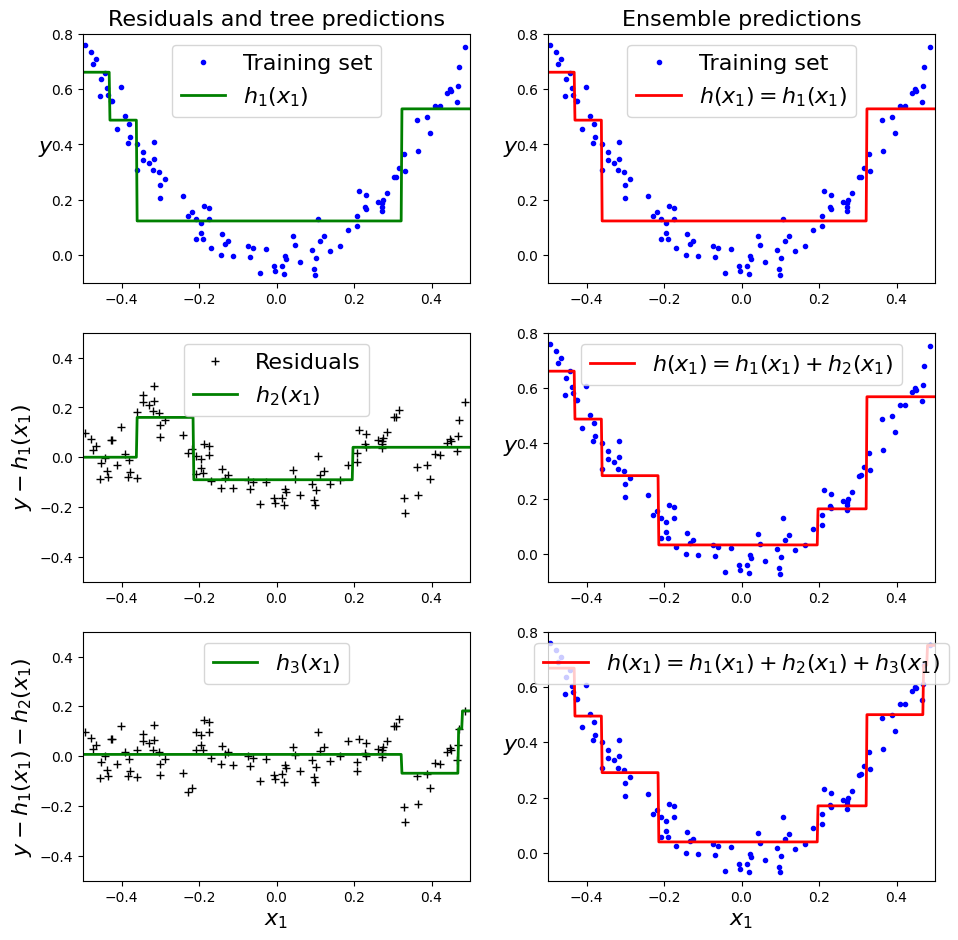

In [31]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

왼쪽 열이 세 트리의 예측, 오른쪽 열이 앙상블의 예측
=> 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 볼 수 있음.

<br>

사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련 시킬 수 있음.<br>
<br>
#### 매개변수
1. 트리 수(n_estimators): 앙상블 훈련을 제어
2. max_depth, min_samples_leaf: 결정 트리의 성장을 제어
3. learning_rate: 각 트리의 기여 정도 조절 
0.1처럼 낮게할 경우 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아짐. => 이렇게 할 경우 **축소**(shrinkage)라 부르는 규제 방법

In [33]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [34]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

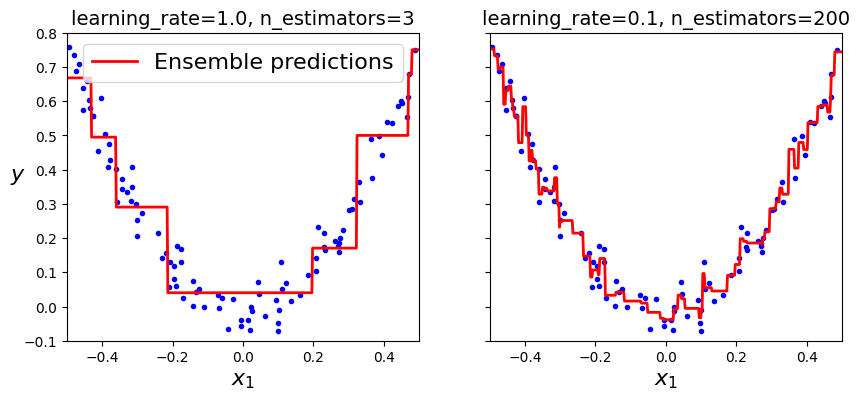

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

=> 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련세트에 과대적합 되었음.

최적의 트리 수를 찾기 위해 조기 종료 기법을 사용할 수 있음. <br>
이를 간단하게 구현하는 방법으로는 staged_predict() 메서드 사용.<br>
-> 이는 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자(iterator)를 반환

다음 코드는 120개의 트리로 GBRT 앙상블 훈련시키고 최적의 트리 수 찾기 위해 각 훈련 단계에서 검증 오차 측정

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) # 120개의 트리로 GBRT 앙상블 훈련
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1  # 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증오차 측정

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators) # 최적의 트리수를 사용해서 마지막으로 훈련하기
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=53)

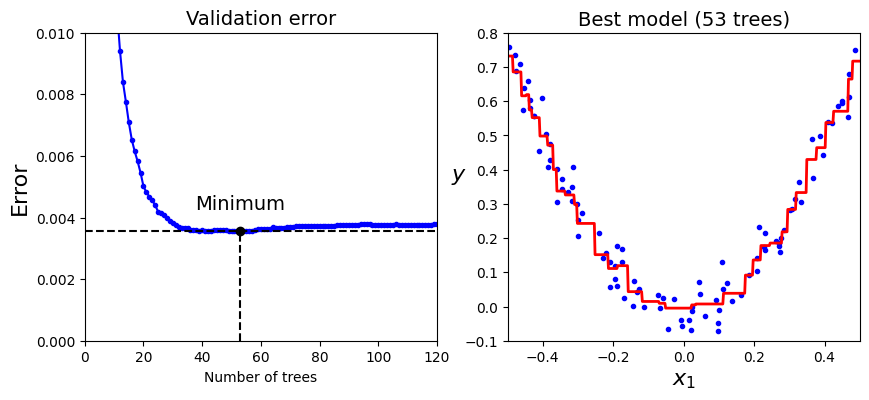

In [39]:
# 시각화
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

실제로 훈련을 중지하는 방법으로 조기 종료 구현하는 방법<br>
`warm_start=True` 로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌.

In [40]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면
            break  # 조기종료

GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원. 이런 식으로 훈련 속도를 높이는 방법을 **확률적 그레이디언트 부스팅**(stochastic gradient boosting)이라 함.<br>
예를 들어 subsample=0.25라 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습됨.

참고) 그레이디언트 부스팅에 다른 비용함수를 사용할 수도 있음. 이때는 loss 매개변수 이용하여 지정.

<br>

최적화된 그레이디언트 부스팅 구현으로 **XGBoost** 파이썬 라이브러리가 유명.<br>
이는 매우 빠른 속도, 확장성, 이식성의 장점이 있음.

In [42]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.1 MB/s eta 0:00:0000:0100:01m


In [44]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)           

Validation MSE: 0.0039984110306231085


XGBoost에서는 자동 조기 종료와 같은 여러 좋은 기능도 제공

In [45]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.21083
[1]	validation_0-rmse:0.14897
[2]	validation_0-rmse:0.11373
[3]	validation_0-rmse:0.09167
[4]	validation_0-rmse:0.07759
[5]	validation_0-rmse:0.06909
[6]	validation_0-rmse:0.06445
[7]	validation_0-rmse:0.06278
[8]	validation_0-rmse:0.06152
[9]	validation_0-rmse:0.06114
[10]	validation_0-rmse:0.06077
[11]	validation_0-rmse:0.06146
[12]	validation_0-rmse:0.06154
Validation MSE: 0.0036926766442669746


## 7.6 스태킹

**스태킹**(stacking): 앙상블에 속한 모든 예측기의 예측을 취합할 수 있는 간단한 함수(직접 투표 등)를 사용하는 대신 취합하는 모델을 훈련시키는 방법

여기서 취합하는 모델 겸 마지막 예측기: 블렌더(blender) 또는 메타 학습기(meta learner)

일반적으로 블렌더를 학습시키는 방법으로 홀드아웃(hold-out)세트를 사용
1. 먼저 훈련 세트를 두 개의 서브셋으로 나눈다.
첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨.
2. 그 다음 첫 번째 레이어의 예측기를 사용해 두 번째 (홀드아웃) 세트에 대한 예측을 만든다.
예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못해기 때문에 이때 만들어진 예측은 완전히 새로운 것.
3. 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.
4. 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다.